In [4]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import os

os.sys.path.append(os.path.dirname(os.path.abspath('..')))

from util import model_utils
from util.modified_models import resnet
from util.visualization import attr_to_subplot
from util.attribution_methods import saliencyMethods as attr
from util.attribution_methods import MDAFunctions
from util.test_methods import MASTestFunctions as MAS
from util.attribution_methods.lime import limeAttr
from util.attribution_methods import GIGBuilder as GIG_Builder
from util.attribution_methods import AGI as AGI
from captum.attr import GuidedBackprop, LayerActivation, LayerGradCam, GradientShap, GuidedGradCam, FeatureAblation, Occlusion, ShapleyValueSampling, KernelShap
from util.attribution_methods import XRAIBuilder as XRAI

model = models.resnet101(weights = "ResNet101_Weights.IMAGENET1K_V2")
model = model.eval()
model.to("cuda:0")

gbp_modified_model = resnet.resnet101(weights = "ResNet101_Weights.IMAGENET1K_V2")
gbp_modified_model = gbp_modified_model.eval()
gbp_modified_model.to("cuda:0")

# standard image resize dimension for ResNet
img_hw = 224

# transforms for IG, LIG, and IDG
transform = transforms.Compose([
     transforms.Resize((img_hw)),
     transforms.CenterCrop(img_hw),
     transforms.ToTensor()
])

# standard ImageNet normalization for IG, LIG, and IDG
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
)

# invert standard ImageNet normalization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

# transforms and normalization for GIG and AGI
resize = transforms.Resize((img_hw, img_hw))
crop = transforms.CenterCrop(img_hw)
normalize = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

norm_cmap = LinearSegmentedColormap.from_list(
    'custom_blue_light',
    [
        (0.00, (1.00, 1.00, 1.00)),   # white
        (0.25, (0.35, 0.40, 1.00)),   # very light blue
        (0.50, (0.25, 0.30, 1.00)),
        (0.75, (0.15, 0.20, 1.00)),
        (1.00, (0.00, 0.00, 1.00))    # full blue
    ],
    N=256
)

# heatmap
def heatmap_overlap(img, attr, name, alpha = 1):
     fig, axs = plt.subplots(1, 1)
     attr_to_subplot(attr, name, axs, cmap = norm_cmap, norm = 'absolute', blended_image = img, alpha = alpha)
     # attr_to_subplot(attr, name, axs, cmap = cmap, norm = 'absolute', blended_image = img, alpha = alpha)

     return

# heatmap
def heatmap_overlap_axs(img, attr, name, axs, alpha = 0.6):
     attr_to_subplot(attr, name, axs, cmap = norm_cmap, norm = 'absolute', blended_image = img, alpha = 1)
     # attr_to_subplot(attr, name, axs, norm = 'absolute', blended_image = img, alpha = 1)
     return

In [9]:
image_path = "../../../../ImageNet/ILSVRC2012_val_00000003.JPEG"
# image_path = "zebra_0.jpg"
# image_path = "2025_05_22_0u9_Kleki.png"

36.320960521698 Shetland sheepdog


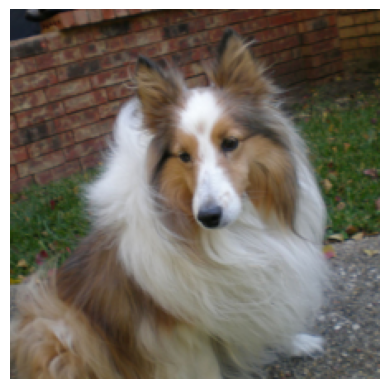

In [10]:
img = Image.open(image_path)
if img.mode != "RGB":
    img = img.convert("RGB")
trans_img = transform(img)

input_tensor = normalize(trans_img).unsqueeze(0)

device = "cuda:0"

target_class = model_utils.getClass(input_tensor, model, device)
# open the class list so the detected class string can be returned for printing
with open('../../util/class_maps/ImageNet/imagenet_classes.txt') as f:
    classes = [line.strip() for line in f.readlines()]
name = classes[target_class]
print(model_utils.getPrediction(input_tensor, model, device, target_class)[0] * 100, name)

plt.axis("off")
plt.imshow(np.transpose(trans_img.numpy(), (1, 2, 0)))
plt.show()

In [4]:
steps = 50
batch_size = 25
baseline = 0

# Grad
input_tensor.requires_grad = True
grad, _ = attr.getGradientsParallel(input_tensor.to(device), model, target_class)
input_tensor.requires_grad = False

# Input x Grad
input_x_grad = input_tensor.squeeze() * grad.cpu()

# IG
ig = attr.IG(input_tensor, model, steps, batch_size, 1, baseline, device, target_class)

# Left IG
lig = attr.IG(input_tensor, model, steps, batch_size, .9, baseline, device, target_class)

# IDG
idg = attr.IDG(input_tensor, model, steps, batch_size, baseline, device, target_class)

# SmoothGrad
sg, attrs, imgs = attr.smoothGrad("IG", input_tensor.to(device), model, 50, baseline, target_class, device, vis = True)

# XRAI
xrai_object = XRAI.XRAI()
xrai = xrai_object.GetMask(input_tensor.squeeze().permute(1, 2, 0), base_attribution = ig.permute(1, 2, 0).cpu().detach()).reshape((224, 224, 1))

# GC
layer = model.layer4
layer_gc = LayerGradCam(model, layer)
input_tensor.requires_grad = True
gc = layer_gc.attribute(input_tensor.to(device), target_class, relu_attributions=True)
input_tensor.requires_grad = False
gc = resize(gc.squeeze().reshape((1, 7, 7))).reshape((1, 224, 224)).cpu() * torch.ones((3, 224, 224))

# CAM
layer_cam = LayerActivation(model, layer)
input_tensor.requires_grad = True
cam = layer_cam.attribute(input_tensor.to(device))
input_tensor.requires_grad = False
cam = resize(cam.squeeze().mean(0).reshape((1, 7, 7))).reshape((1, 224, 224)).cpu() * torch.ones((3, 224, 224))

# GGC
guided_gc = GuidedGradCam(gbp_modified_model, gbp_modified_model.layer4)
input_tensor.requires_grad = True
ggc = guided_gc.attribute(input_tensor.to(device), target_class)
input_tensor.requires_grad = False

# GBP
guided_bp = GuidedBackprop(gbp_modified_model)
input_tensor.requires_grad = True
gbp = guided_bp.attribute(input_tensor.to(device), target = target_class)
input_tensor.requires_grad = False

# GIG
call_model_args = {'class_idx_str': target_class.item()}
guided_ig = GIG_Builder.GuidedIG()
baseline = torch.zeros_like(input_tensor)
gig = guided_ig.GetMask(input_tensor, model, device, GIG_Builder.call_model_function, call_model_args, x_baseline=baseline, x_steps=steps, max_dist=1.0, fraction=0.5)

# AGI from https://github.com/pd90506/AGI/blob/master/AGI_main.py
epsilon = 0.05
topk = 1
max_iter = 20
agi_img = trans_img.permute(1, 2,0).numpy().astype(np.float32) 
mean = transform_normalize.mean
std = transform_normalize.std
norm_layer = AGI.Normalize(mean, std)
modified_model = nn.Sequential(norm_layer, model).to(device)        
selected_ids = range(0, 999, int(1000 / topk))
_, _, agi = AGI.test(modified_model, device, agi_img, epsilon, topk, selected_ids, max_iter)
percentile = 80
upperbound = 99
hm = agi
hm = np.mean(hm, axis=0)
q = np.percentile(hm, percentile)
u = np.percentile(hm, upperbound)
hm[hm<q] = q
hm[hm>u] = u
hm = (hm-q)/(u-q)
agi = np.reshape(hm, (img_hw, img_hw, 1))

# LIME
img_lime = trans_img.permute(1, 2, 0).numpy().astype(np.float32) 
lime = limeAttr.get_lime_attr(img_lime, model, device)

num_patches = 14
downsize = transforms.Resize((num_patches, num_patches), interpolation=transforms.InterpolationMode.NEAREST_EXACT)
patch_ids = torch.arange(num_patches ** 2).reshape((num_patches, num_patches))
patch_mask = patch_ids.repeat_interleave(int(img_hw / num_patches), dim=0).repeat_interleave(int(img_hw / num_patches), dim=1).to(device)

# FA
ablator = FeatureAblation(model)
FA = resize(downsize(ablator.attribute(input_tensor.to(device), target=target_class, feature_mask=patch_mask)))

# OCC
ablator = Occlusion(model)
OCC = resize(downsize(ablator.attribute(input_tensor.to(device), target=target_class, sliding_window_shapes=(3,8,8), strides=4)))

# Kernel SHAP
ks = KernelShap(model)
kernel_shap = ks.attribute(input_tensor.to(device), target=target_class, feature_mask=patch_mask, perturbations_per_eval = 50, n_samples = 200)

# SHAP
svs = ShapleyValueSampling(model)
shap_patch = svs.attribute(input_tensor.to(device), target=target_class, feature_mask=patch_mask, perturbations_per_eval = 50)

# Grad Shap
baselines = torch.randn(50, 3, 224, 224)
gradient_shap = GradientShap(model)
gs = gradient_shap.attribute(input_tensor.to(device), baselines.to(device), n_samples = 50, target = target_class)

/home/chasewalker/Desktop/XAIcode/.venv/lib/python3.12/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


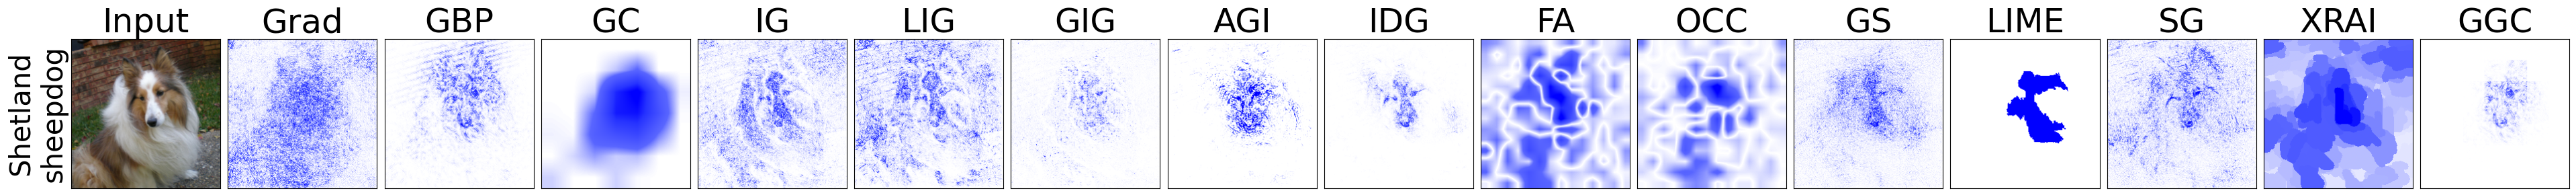

In [11]:
grad_print = np.transpose(grad.squeeze().detach().cpu().numpy(), (1,2,0))
ig_print = np.transpose(ig.squeeze().detach().cpu().numpy(), (1,2,0))
lig_print = np.transpose(lig.squeeze().detach().cpu().numpy(), (1,2,0))
idg_print = np.transpose(idg.squeeze().detach().cpu().numpy(), (1,2,0))
sg_print =  np.transpose(sg.squeeze().detach().cpu().numpy(), (1,2,0))
gc_print = np.transpose(gc.squeeze().detach().cpu().numpy(), (1,2,0))
ggc_print = np.transpose(ggc.squeeze().detach().cpu().numpy(), (1,2,0))
gbp_print = np.transpose(gbp.squeeze().detach().cpu().numpy(), (1,2,0))
gig_print = np.transpose(gig.squeeze().detach().cpu().numpy(), (1, 2, 0))
agi_print = agi
lime_print = np.transpose(lime.squeeze().detach().cpu().numpy(), (1, 2, 0))
FA_print = np.transpose(FA.squeeze().detach().cpu().numpy(), (1, 2, 0))
OCC_print = np.transpose(OCC.squeeze().detach().cpu().numpy(), (1, 2, 0))
gs_print = np.transpose(gs.squeeze().detach().cpu().numpy(), (1,2,0))
xrai_print = xrai

plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(1, 16, figsize = (48, 3))
attr_to_subplot(trans_img, "Input", axs[0], original_image = True)
heatmap_overlap_axs(trans_img, grad_print, 'Grad', axs[1])
heatmap_overlap_axs(trans_img, gbp_print, 'GBP', axs[2])
heatmap_overlap_axs(trans_img, gc_print, 'GC', axs[3])
heatmap_overlap_axs(trans_img, ig_print, 'IG', axs[4])
heatmap_overlap_axs(trans_img, lig_print, 'LIG', axs[5])
heatmap_overlap_axs(trans_img, gig_print, 'GIG', axs[6])
heatmap_overlap_axs(trans_img, agi_print, 'AGI', axs[7])
heatmap_overlap_axs(trans_img, idg_print, 'IDG', axs[8])
heatmap_overlap_axs(trans_img, FA_print, 'FA', axs[9])
heatmap_overlap_axs(trans_img, OCC_print, 'OCC', axs[10])
heatmap_overlap_axs(trans_img, gs_print, 'GS', axs[11])
heatmap_overlap_axs(trans_img, lime_print, 'LIME', axs[12])
heatmap_overlap_axs(trans_img, sg_print, 'SG', axs[13])
heatmap_overlap_axs(trans_img, xrai_print, 'XRAI', axs[14])
heatmap_overlap_axs(trans_img, ggc_print, 'GGC', axs[15])
axs[0].set_ylabel(name.replace(" ", "\n"))
plt.subplots_adjust(wspace = 0.05)
plt.show()
fig.savefig('my_plot.png', dpi=100, bbox_inches='tight')